In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import statsmodels.api as sm
import tkinter as tk
from numba import njit
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta, SU
from scipy.interpolate import PchipInterpolator

from sklearn.preprocessing import StandardScaler
from functools import reduce
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime


In [2]:
working_directory = "C:/Users/wachic/OneDrive - Milwaukee School of Engineering/Documents/GitHub/Undergrad_Research/"

# Naming convention
# MMSD_sewerflow_all_dailyavg_df
# 1.  [MMSD, USGS] Where the source is
# 2.  [sewerflow, precip, streamflow] What the data measures
# 3.  [all, dry, wet] what season it includes
# 4-n What ever operation has been done to the data
# n+1 [df, periods, csv] data type

USGS_stream_flow_all_df = pd.read_csv(working_directory + "USGS 04087030 Streamflow Cleaned.csv")
MMSD_sewerflow_all_df = pd.read_csv(working_directory + "MMSD Sewer Flow Cleaned.csv")
MMSD_flow_and_precip_all_df = pd.read_csv(working_directory + "MMSD Flow and Precipitation Cleaned.csv")
MMSD_precip_all_df = pd.read_csv(working_directory + "MMSD Precipitation Raw Data Cleaned.csv")

df_list = [USGS_stream_flow_all_df,
           MMSD_sewerflow_all_df,
           MMSD_flow_and_precip_all_df,
           MMSD_precip_all_df]

In [3]:
for df in df_list:
    df['Date Time'] = pd.to_datetime(df['Date Time'])

# Removing Diurnal Variation

In [4]:
def export(df, name='export_df'):
    csv = df.to_csv(f'{name}.csv', index = False) 

In [5]:
def shift_one(df):
    df = df.copy()
    df.iloc[:, 1:] = df.iloc[:, 1:].shift(-1)

    return df

In [6]:
def create_total_col(df):
    """
    Adds on a 'total' column
    Used for precipitaiton df when calculating dry period
    """
    df = df.copy()
    df['total'] = df.loc[:, df.columns[df.columns.get_loc('Date Time') + 1:]].sum(axis=1)
    return df

In [7]:
def diff(df1, df2):
    """
    create df that is the difference of two df
    """
    df1 = df1.copy()
    df2 = df2.copy()
    columns_to_subtract =  [col for col in df1.columns if col != 'Date Time']

    df_diff = df1.copy()  
    df_diff[columns_to_subtract] = df1[columns_to_subtract] - df2[columns_to_subtract]
    return df_diff

In [8]:
def set_na(edit_df, with_na_df):
    """
    re-sets any nan values from
    """
    edit_df = edit_df.copy()
    with_na_df = with_na_df.copy()
    edit_df[with_na_df.isna()] = np.nan
    return edit_df

In [9]:
def repeat_df(time_series_df, df, num):
    """
    repeats the daily avg df so it's easier to compare when aligned with other df
    """
    time_series_df = time_series_df.copy()
    df = df.copy()
    extended_df = pd.concat([df] * num, ignore_index=True)
    extended_df['Date Time'] = time_series_df['Date Time']
    return extended_df

In [10]:
def standardize(df1, df2):
    """
    Standardize 2 df with same columns
    Combines vertically, standardize, then separate and return
    Returns the two seprate std df and 2 df with mean and with std.dev in each column
    """
    df1 = df1.copy()
    df2 = df2.copy()
    scaler = StandardScaler()
    df = pd.concat([df1, df2], ignore_index=True)
    df = df.reset_index(drop=True)
    
    df_to_standardize = df.drop(columns=['Date Time'], inplace=False)
    standardized_values = scaler.fit_transform(df_to_standardize)

    # Create standardized DataFrame
    df = pd.concat([df['Date Time'], pd.DataFrame(standardized_values, columns=df_to_standardize.columns)], axis=1)

    # Compute mean and standard deviation of each column
    mean_df = pd.DataFrame(df_to_standardize.mean(), columns=['Mean']).T
    std_dev_df = pd.DataFrame(df_to_standardize.std(), columns=['Standard Deviation']).T

    df.columns = df.columns
    df1_out = df.iloc[:len(df1)].reset_index(drop=True)
    df2_out = df.iloc[len(df1):].reset_index(drop=True)
    
    return df1_out, df2_out, std_dev_df, mean_df
    
def revert_standardize(df, std_dev_df, mean_df):
    """
    From a standardized df and its means and std.dev, reverts back to normal scale values
    """
    df = df.copy()
    std_dev_df = std_dev_df.copy()
    mean_df = mean_df.copy()
    columns = [col for col in df1.columns if col != 'Date Time']
    df_original = df.copy()
    
    df_original[columns] = (df_original[columns] * std_dev_df.loc['Standard Deviation', columns]) + mean_df.loc['Mean', columns]
    return df_original
    

In [11]:
def get_cst(years):
    """
    Returns list of tuple of range of CDT that starts on year in years
    """
    dates = []
    for year in years:
        # Get the first day of November
        first_nov = date(year, 11, 1)
        # Find the second Sunday
        nov_first_sunday = first_nov + relativedelta(weekday=SU(+1))
        datetime_nov = datetime(year, 11, nov_first_sunday.day, 1, 0, 0)
        
        # Get the first day of March
        first_march = date(year+1, 3, 1)
        # Find the second Sunday
        march_second_sunday = first_march + relativedelta(weekday=SU(+2))
        datetime_march = datetime(year+1, 3, march_second_sunday.day, 3, 0, 0)

        
        dates.append((datetime_nov,datetime_march))
    return dates
    

In [12]:
def shift_year(df, date_range, amount):
    """
    if date time is with in the ranges in date_range, the value is shifted by 'amount'
    """
    df = df.copy()
    
    # Create mask for all date ranges
    columns_to_edit = [col for col in df.columns if col != 'Date Time']
    
    mask = reduce(lambda x, y: x | y, [df['Date Time'].between(start, end) for start, end in date_range])
    
    # Shift hours where the mask is True
    df.loc[mask,columns_to_edit] = df.loc[mask,columns_to_edit].shift(amount)
    
    return df

In [13]:
def find_consecutive_dry_period(df, dry_length=8, days_after=7, precip_threshold=0):
    """
    Finds dry period from precipitation df. 
    Can select the length of days there must be without rain to be "dry"(dry_length)
    The grace period where data isnt used. Only days after this period is used (days_after)
    and what amount of precipitation is considered a rainfall (precip_threshold)
    """
    df = df.copy()

    # Create a boolean series where True represents dry days
    dry_days = df['total'] <= precip_threshold

    # Find the start and end indices of consecutive dry periods
    df['dry_group'] = (dry_days != dry_days.shift()).cumsum() * dry_days

    dry_periods = df[df['dry_group'] > 0].groupby('dry_group').agg(
        start_date=('Date Time', 'first'),
        end_date=('Date Time', 'last'),
        length=('Date Time', 'size')
    )

    # Filter by dry length
    dry_periods = dry_periods[dry_periods['length'] >= dry_length]

    # Apply days_after adjustment
    dry_periods['start_date'] += pd.to_timedelta(days_after, unit='D')

    # Return as list of tuples
    zero_ranges = list(zip(dry_periods['start_date'], dry_periods['end_date']))

    return zero_ranges


In [14]:
def select_dry_period(df, dry_period):
    """
    Selects rows that are within the given dry_period
    """
    df = df.copy()
    mask = reduce(lambda x, y: x | y, [(df['Date Time'].between(start, end)) for start, end in dry_period])
    
    filtered_df = df[mask].reset_index(drop=True)
    return filtered_df

In [15]:
def avg_days_of_week(df):
    """
    Calculates the average of each hour and day of week, and returns values. [Sun 0:00AM to Sat 23:00PM]
    Subtracts min() from each column, so min is 0
    """
    df = df.copy()
    # Group by weekday (Sunday=0, Saturday=6) and hour
    df['weekday'] = df['Date Time'].dt.weekday  # Monday=0, Sunday=6
    df['hour'] = df['Date Time'].dt.hour
    
    # Adjust weekday order to start from Sunday (moving Sunday=6 to 0)
    df['weekday'] = (df['weekday'] + 1) % 7  # Convert Monday=0 → Sunday=0
    
    hourly_avg = df.groupby(['weekday', 'hour']).mean()
    df = df.drop(columns=['weekday', 'hour'], errors='ignore')
    hourly_avg = hourly_avg.drop(columns=['weekday', 'hour'], errors='ignore')
    hourly_avg.columns = df.columns
    
    # # Sort the values correctly from Sunday 00:00 to Saturday 23:00
    hourly_avg = hourly_avg.sort_values(by=['weekday', 'hour'])

    # Just a refernce datetime from Sun 0:00 to Sat 23:00
    date_range = pd.date_range(start="2025-02-02 00:00", end="2025-02-08 23:00", freq="h")
    
    hourly_avg['Date Time'] = date_range
    
    num_cols = [col for col in hourly_avg.columns if col != 'Date Time']
    hourly_avg[num_cols] = hourly_avg[num_cols] - hourly_avg[num_cols].min()
    
    return hourly_avg[['Date Time'] + [col for col in hourly_avg.columns if col != 'Date Time']]

In [16]:
def subtract_diurnal(orig_df, correction_df):
    """
    Subtracts the corresponding hourly and weekday values from correction_df from orig_df for each data point.
    """
    orig_df = orig_df.copy()
    correction_df = correction_df.copy()

    columns_to_subtract = [col for col in orig_df.columns if col != 'Date Time']

    orig_df['weekday'] = orig_df['Date Time'].dt.weekday
    orig_df['hour'] = orig_df['Date Time'].dt.hour
    correction_df['weekday'] = correction_df['Date Time'].dt.weekday
    correction_df['hour'] = correction_df['Date Time'].dt.hour

    # Set multi-index on weekday and hour
    orig_df.set_index(['weekday', 'hour'], inplace=True)
    correction_df.set_index(['weekday', 'hour'], inplace=True)

    # Reindex correction_df to align with orig_df
    correction_df = correction_df.reindex(orig_df.index)

    orig_numeric = orig_df[columns_to_subtract]
    correction_numeric = correction_df[columns_to_subtract]

    # Perform subtraction in a vectorized manner
    result_numeric = orig_numeric - correction_numeric

    result_numeric.reset_index(inplace=True)
    orig_df.reset_index(inplace=True)

    # Add 'Date Time' column back to result
    result_numeric.insert(0, 'Date Time', orig_df['Date Time'])

    # Drop 'weekday' and 'hour' columns
    result_numeric.drop(columns=['weekday', 'hour'], inplace=True)
    return result_numeric


In [17]:
def get_ref_diurnal(data_df, avg_df):
    edit_df = data_df.copy()
    avg_df = avg_df.copy()
    columns_to_edit = [col for col in edit_df.columns if col != 'Date Time']
    
    edit_df["day_of_week"] = edit_df['Date Time'].dt.dayofweek
    avg_df["day_of_week"] = avg_df['Date Time'].dt.dayofweek
    
    max_values = avg_df.groupby("day_of_week").max()
    
    # def filter_values(row):
    #     day = row["day_of_week"]
    #     return row.drop("day_of_week") <= max_values.loc[day]
    
    # mask = edit_df.apply(filter_values, axis=1)
    mask = edit_df.drop(columns="day_of_week").le(max_values.reindex(edit_df["day_of_week"]).values)

    out_df = edit_df.where(mask).drop(columns=["day_of_week"]).reset_index()
    
    out_df['date'] = out_df['Date Time'].dt.date
    
    # Check if any NaN exists within each date group
    has_nan = out_df.groupby('date').transform(lambda x: x.isna().any())
    
    out_df[columns_to_edit] = out_df[columns_to_edit].where(~has_nan, np.nan)
    
    out_df.drop(columns=['date'], inplace=True)
    out_df['Date Time'] = data_df['Date Time']
    out_df = out_df.reset_index(drop=True)
    return out_df

In [18]:
def insert_mirrored_rows(df, num_rows=30):
    """
    Insert chronologically mirrored data point at head and tail of df
    """
    df = df.copy()
    mirrored_rows_head = df.iloc[:num_rows].copy()
    mirrored_rows_head = mirrored_rows_head.iloc[::-1].reset_index(drop=True)

    mirrored_rows_tail = df.iloc[-num_rows:].copy()
    mirrored_rows_tail = mirrored_rows_tail.iloc[::-1].reset_index(drop=True)

    df_extended = pd.concat([mirrored_rows_head, df, mirrored_rows_tail], ignore_index=True)
    
    return df_extended

### Smoothing Functions

In [19]:
def moving_avg(df, length=24):
    """ 
    Finds moving average for past 24 hour
    """
    df = insert_mirrored_rows(df.copy())
    # columns_to_edit = [col for col in df.columns if col != 'Date Time']
    # out_df = df.copy()
    # for col in columns_to_edit:
    #     out_df[col] = df[col].rolling(window=length).mean()
    out_df = df.set_index('Date Time').rolling(window=length).mean().reset_index()
    return out_df.iloc[30:-30].reset_index(drop=True)
    
def moving_avg_mid(df, lengths=[3]):
    """ 
    Finds centered moving averages for given window lengths.
    Overwrites the same columns on each iteration.
    """
    df = insert_mirrored_rows(df.copy())
    columns_to_edit = [col for col in df.columns if col != 'Date Time']
    numeric_df = df[columns_to_edit]
    for length in lengths:
        df[columns_to_edit] = df[columns_to_edit].rolling(window=length, center=True).mean()

    return df.iloc[30:-30].reset_index(drop=True)


In [20]:
def PCHIP(df, passes=1):
    """
    A filter method that connects all local minima with a smoothing function
    Number of passes doesn't have to be odd, can be even
    """
    df = df.copy()
    df.ffill(inplace=True)
    timestamps = df['Date Time'].astype(np.int64) // 10**9  # to seconds
    timestamps_linspace = np.linspace(timestamps.min(), timestamps.max(), len(df))
    x = timestamps_linspace

    def apply_pchip(col):
        y = col.to_numpy()
        
        # Identify local minima
        local_minima_indices = argrelextrema(y, np.less)[0]
        
        # Extract x and y values at local minima
        x_minima = x[local_minima_indices]
        y_minima = y[local_minima_indices]
        
        # Create a PCHIP interpolator
        pchp_interpolator = PchipInterpolator(x_minima, y_minima)
        
        # Evaluate the interpolator on the original x values
        return pchp_interpolator(x)
    columns_to_work = [col for col in df.columns if col != 'Date Time']
    # Apply PCHIP interpolation to all columns (except 'Date Time')
    df[columns_to_work] = df[columns_to_work].apply(apply_pchip)

    if passes > 1:
        return PCHIP(df, passes-1)
    else:
        return df

def PCHIP_init(df, passes=1):
    """
    Call this method for practicality, won't lose accuracy in beginning and end by adding padding
    """
    df = df.copy()
    return PCHIP(insert_mirrored_rows(df), passes).iloc[30:-30].reset_index(drop=True)
    

In [21]:
@njit
def lyne_hollick_numba(data, alpha):
    n_rows, n_cols = data.shape
    out = np.copy(data)  # Copy input data to output array
    oneplusalphahalf = (1 + alpha) / 2

    for col in range(1, n_cols):
        out[0, col] = data[0, col]
        prev_out = data[0, col]
        prev_data = data[0, col]

        for row in range(1, n_rows):
            cur_data = data[row, col]

            # Handle NaN values explicitly
            if np.isnan(cur_data):
                out[row, col] = prev_out  # Retain previous output if NaN is encountered
                continue

            term1 = alpha * (prev_data - prev_out)
            term2 = oneplusalphahalf * (cur_data - prev_data)
            cur_out = cur_data - max(term1 + term2, 0)

            # Ensure numerical stability
            if np.isnan(cur_out) or cur_out <= 0:
                cur_out = prev_out

            out[row, col] = cur_out
            prev_out = cur_out
            prev_data = cur_data

    return out

def lyne_hollick(df, passes=1, alpha=0.925):
    """
    Applies the Lyne-Hollick filter recursively with optimization.
    Number of passes should be odd.
    """
    if passes < 1:
        return df

    df = df.copy()
    reverse_pass = (passes % 2 == 0)
    if reverse_pass:
        df = df.iloc[::-1].reset_index(drop=True)

    # Flatten MultiIndex if necessary
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [' '.join(map(str, col)).strip() for col in df.columns]

    # Convert DataFrame to NumPy array (ensure float type)
    data = df.to_numpy(dtype=np.float64)

    # Apply Numba-optimized function
    filtered_data = lyne_hollick_numba(data, alpha)

    # Convert back to DataFrame
    out_df = pd.DataFrame(filtered_data, columns=df.columns)

    if reverse_pass:
        out_df = out_df.iloc[::-1].reset_index(drop=True)

    return lyne_hollick(out_df, passes - 1, alpha) if passes > 1 else out_df


def lyne_hollick_init(df, passes=1, alpha=0.925):
    """
    Call this method for practicality, won't lose accuracy in beginning and end by adding padding
    """
    df_padded = insert_mirrored_rows(df)
    result = lyne_hollick(df_padded, passes, alpha)
    return result.iloc[30:-30].reset_index(drop=True)

In [22]:
def remove_diurnal(sewer_df, precip_df):
    """
    Just runs all the methods for you
    sewer_df: df in which you want to remove diurnal variation
    precip_df: precipitation df to determine dry period
    """
    # General flow:
    # Step 1. Finds a temporary daily diurnal variation for dry season(determined from precip data),
    #         and calculate the hourly average from sunday to saturday
    # 2. Calculates temporary smooth function of base flow of sewer data. This is not the output data
    # 3. Calculates a rough diurnal variation accross all data by subtracting (raw - LH7)
    # 4. Select days to use to calculate the avg variation, find the hourly avg for the week from the diurnal curve from 3 
    # 5. Subtracts the newly diurnal variation from the raw data
    # 6. Smooths out resulting df a little bit
    # 7. Re-sets any nan value that was present in the raw data, since they were filled in at onepoint
    
    # Step 1
    precip_all_df = create_total_col(precip_df)
    precip_dry_periods = find_consecutive_dry_period(precip_all_df, 10, 9, 0.0)
    sewerflow_dry_df = select_dry_period(sewer_df, precip_dry_periods)
    sewerflow_dry_dailyavg_df = avg_days_of_week(sewerflow_dry_df)
    #####
    out_df = subtract_diurnal(sewer_df, sewerflow_dry_dailyavg_df)
    #####
    # 2
    sewerflow_all_LH7_df = lyne_hollick_init(sewer_df, 7, 0.925)
    sewerflow_all_LH7_df['Date Time'] = pd.to_datetime(sewerflow_all_LH7_df['Date Time'])
    # 3
    sewerflow_all_LH7_diurnal_isolated_df = diff(sewer_df, sewerflow_all_LH7_df)
    # 4
    sewerflow_all_reference_diurnal_df = get_ref_diurnal(sewerflow_all_LH7_diurnal_isolated_df, sewerflow_dry_dailyavg_df)
    sewerflow_all_newdiurnal_dailyavg_df = avg_days_of_week(sewerflow_all_reference_diurnal_df)
    # 5
    sewerflow_all_removed_df = subtract_diurnal(sewer_df, sewerflow_all_newdiurnal_dailyavg_df)
    # 6
    sewerflow_all_removed_movingCenterAvg_df = moving_avg_mid(sewerflow_all_removed_df, [3,3,3,5])
    # 7
    sewerflow_all_removed_withna_df = set_na(sewerflow_all_removed_movingCenterAvg_df, sewer_df)
    
    return sewerflow_all_removed_withna_df, sewerflow_all_newdiurnal_dailyavg_df, sewerflow_all_reference_diurnal_df, sewerflow_all_LH7_diurnal_isolated_df, sewerflow_dry_df, out_df, sewerflow_all_LH7_df

In [23]:
# There was a fault in data collection provided from MMSD, where calibration for CST was not proper, 
# So I manually pointed out which year had to be fixed, and the following method shifts the data points.
cst_date_range = get_cst([2017,2018])
MMSD_copy_df = MMSD_sewerflow_all_df.copy()
# MMSD_sewerflow_all_df = shift_year(MMSD_sewerflow_all_df, cst_date_range, -1)

In [24]:
%%time
MMSD_sewerflow_diurnal_removed_df, daily_avg_df, ref_df, isolated_df, dry_period_df, out_df, lh7df = remove_diurnal(MMSD_sewerflow_all_df, MMSD_precip_all_df)
MMSD_sewerflow_baseflow_df = lyne_hollick_init(MMSD_sewerflow_diurnal_removed_df, 7, 0.925)
MMSD_sewerflow_predicted_precipitation_df = diff(MMSD_sewerflow_diurnal_removed_df, MMSD_sewerflow_baseflow_df)

C:\Users\wachic\AppData\Local\anaconda3\envs\tensorflow\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


CPU times: total: 1.17 s
Wall time: 1.56 s


In [25]:
# export(MMSD_sewerflow_diurnal_removed_df,"MMSD_sewerflow_diurnal_removed_df")
# export(MMSD_sewerflow_baseflow_df,"MMSD_sewerflow_baseflow_df")
# export(MMSD_sewerflow_predicted_precipitation_df,"MMSD_sewerflow_predicted_precipitation_df")

In [26]:
cst_date_range2 = get_cst([2016,2017,2018])
# MMSD_copy_df = shift_year(MMSD_copy_df, cst_date_range2, 0)
# MMSD_sewerflow_diurnal_removed_copy_df = remove_diurnal(MMSD_copy_df, MMSD_precip_all_df)
# MMSD_sewerflow_diurnal_removed_copy_2nd_df = remove_diurnal(MMSD_sewerflow_diurnal_removed_copy_df, MMSD_precip_all_df)

In [27]:
# daily_avg_df = repeat_df(MMSD_sewerflow_diurnal_removed_df, daily_avg_df, 100)

In [28]:
# plt.figure(figsize=(400, 6))

# col_name = 'MS0311 Flow'

# # plt.plot(MMSD_sewerflow_all_df['Date Time'], MMSD_sewerflow_all_df['MS0311 Flow'], linestyle='-', color='r', markersize=6, label="Data Line")
# # plt.plot(daily_avg_df['Date Time'], daily_avg_df[col_name], linestyle='-', color='g', markersize=6, label="Data Line")
# # plt.plot(MMSD_sewerflow_diurnal_removed_df['Date Time'], MMSD_sewerflow_diurnal_removed_df[col_name], linestyle='-', color='r', markersize=6, label="Data Line")
# # plt.plot(ref_df['Date Time'], ref_df[col_name], linestyle='-', color='g', markersize=6, label="Data Line")
# # plt.plot(daily_avg_df['Date Time'], daily_avg_df[col_name], linestyle='-', color='r', markersize=6, label="Data Line")
# plt.plot(MMSD_sewerflow_predicted_precipitation_df['Date Time'], MMSD_sewerflow_predicted_precipitation_df[col_name], linestyle='-', color='b', markersize=6, label="Data Line")

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# plt.grid(True)

# plt.show()

In [29]:
# plt.figure(figsize=(400, 6))

# col_name = 'MS0311 Flow'
# MMSD_sewerflow_baseflow_df['Date Time'] = pd.to_datetime(MMSD_sewerflow_baseflow_df['Date Time'])

# plt.plot(MMSD_sewerflow_all_df['Date Time'], MMSD_sewerflow_all_df[col_name], linestyle='-', color='b', markersize=6, label="Data Line")
# plt.plot(daily_avg_df['Date Time'], daily_avg_df[col_name], linestyle='-', color='g', markersize=6, label="Data Line")
# plt.plot(MMSD_sewerflow_baseflow_df['Date Time'], MMSD_sewerflow_baseflow_df[col_name], linestyle='-', color='r', markersize=6, label="Data Line")
# # plt.plot(isolated_df['Date Time'], isolated_df[col_name], linestyle='-', color='g', markersize=6, label="Data Line")
# # plt.plot(lh_df['Date Time'], lh_df[col_name], linestyle='-', color='r', markersize=6, label="Data Line")
# # plt.plot(MMSD_sewerflow_all_df['Date Time'], MMSD_sewerflow_all_df[col_name], linestyle='-', color='b', markersize=6, label="Data Line")

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# plt.grid(True)

# plt.show()

In [30]:
# ref_df

In [31]:
df = ref_df.dropna(subset=['MS0311 Flow'])

In [32]:
df['hour'] = df['Date Time'].dt.hour
df['date'] = df['Date Time'].dt.date
df['dayofweek'] = df['Date Time'].dt.dayofweek
pivot_df = df.pivot(index='hour', columns='date', values='MS0311 Flow')

# Map each date to its weekday name
weekday_map = {date: pd.to_datetime(date).day_name() for date in pivot_df.columns}

# Define colors for weekdays
weekday_colors = {
    'Monday': 'tab:blue',
    'Tuesday': 'tab:orange',
    'Wednesday': 'tab:green',
    'Thursday': 'tab:red',
    'Friday': 'tab:purple',
    'Saturday': 'tab:brown',
    'Sunday': 'tab:pink'
}
daily_avg_df = daily_avg_df.iloc[1:168,:]
daily_avg_df['Date Time'] = pd.to_datetime(daily_avg_df['Date Time'])
daily_avg_df = daily_avg_df.dropna(subset=['MS0311 Flow'])  # Skip missing values
daily_avg_df['hour'] = daily_avg_df['Date Time'].dt.hour
daily_avg_df['weekday'] = daily_avg_df['Date Time'].dt.day_name()

C:\Users\wachic\AppData\Local\Temp\ipykernel_16980\3192664946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['Date Time'].dt.hour
C:\Users\wachic\AppData\Local\Temp\ipykernel_16980\3192664946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['Date Time'].dt.date
C:\Users\wachic\AppData\Local\Temp\ipykernel_16980\3192664946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

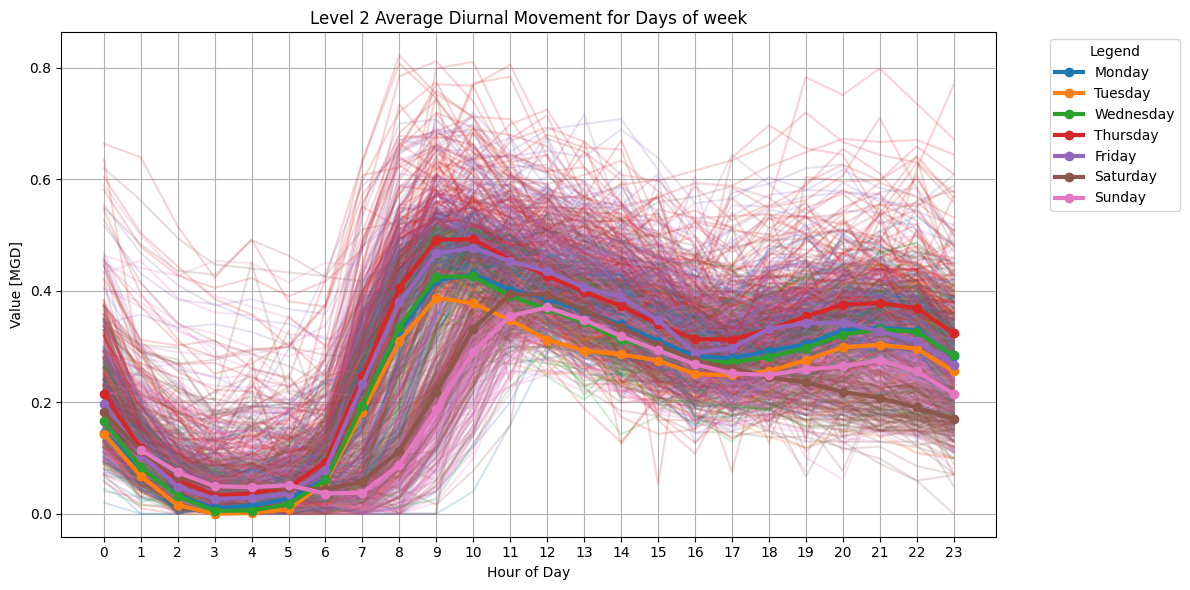

In [33]:
# --- Plot original daily data ---
plt.figure(figsize=(12, 6))
for date in pivot_df.columns:
    weekday = weekday_map[date]
    color = weekday_colors.get(weekday, 'gray')
    plt.plot(pivot_df.index, pivot_df[date], color=color, linewidth=1.5, alpha=0.2)

# --- Overlay average weekday curves ---
for weekday in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
    subset = daily_avg_df[daily_avg_df['weekday'] == weekday]
    if not subset.empty:
        plt.plot(subset['hour'], subset['MS0311 Flow'],
                 color=weekday_colors[weekday],
                 linewidth=3, marker='o', label=f"{weekday}")

# --- Final touches ---
plt.title("Level 2 Average Diurnal Movement for Days of week")
plt.xlabel("Hour of Day")
plt.ylabel("Value [MGD]")
plt.xticks(range(0, 24))
plt.grid(True)

# Deduplicated legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

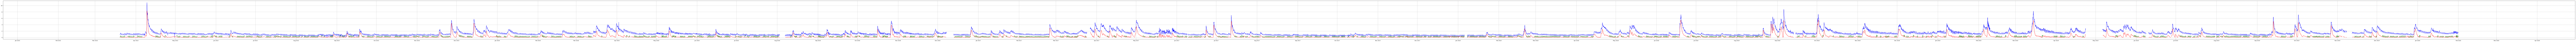

In [34]:
# slow_df = lyne_hollick_init(MMSD_sewerflow_predicted_precipitation_df, 3, 0.925)
plt.figure(figsize=(400, 6))

col_name = 'MS0311 Flow'
# MMSD_sewerflow_baseflow_df['Date Time'] = pd.to_datetime(MMSD_sewerflow_baseflow_df['Date Time'])

plt.plot(MMSD_sewerflow_all_df['Date Time'], MMSD_sewerflow_all_df[col_name], linestyle='-', color='b', markersize=6, label="Data Line")
plt.plot(ref_df['Date Time'], ref_df[col_name], linestyle='-', color='g', markersize=6, label="Data Line")
plt.plot(MMSD_sewerflow_predicted_precipitation_df['Date Time'], MMSD_sewerflow_predicted_precipitation_df[col_name], linestyle='-', color='r', markersize=6, label="Data Line")
# plt.plot(isolated_df['Date Time'], isolated_df[col_name], linestyle='-', color='g', markersize=6, label="Data Line")
# plt.plot(lh_df['Date Time'], lh_df[col_name], linestyle='-', color='r', markersize=6, label="Data Line")
# plt.plot(MMSD_sewerflow_all_df['Date Time'], MMSD_sewerflow_all_df[col_name], linestyle='-', color='b', markersize=6, label="Data Line")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True)

plt.show()

In [35]:
len1 = (dry_period_df.count().sum())
len4 = (ref_df.count().sum())
len2 = (MMSD_sewerflow_all_df.count().sum())
print(len1/len2)
print(len4/len2)

0.0212539262641491
0.486888671519307


In [36]:
print(len2)
print(MMSD_sewerflow_all_df.shape)

1065262
(42696, 26)


In [37]:
def trim(df, event):
    return df[(df['Date Time'] >= event[0]) & (df['Date Time'] <= event[1] - pd.Timedelta(hours=1))].reset_index(drop = True)
    

In [100]:
flow_data = out_df[['Date Time', 'MS0311 Flow']]
flow_data2 = MMSD_sewerflow_diurnal_removed_df[['Date Time', 'MS0311 Flow']]
flow_data3 = MMSD_sewerflow_all_df[['Date Time', 'MS0311 Flow']]
event = (pd.to_datetime('2017-7-7 0:00'), pd.to_datetime('2017-8-10 23:00'))
hourly_range = pd.date_range(start=event[0], end=event[1] - pd.Timedelta(hours=1), freq='h')
flow_event_df = trim(flow_data, event).iloc[:, 1]
flow_event2_df = trim(flow_data2, event).iloc[:, 1]
flow_event3_df = trim(flow_data3, event).iloc[:, 1]


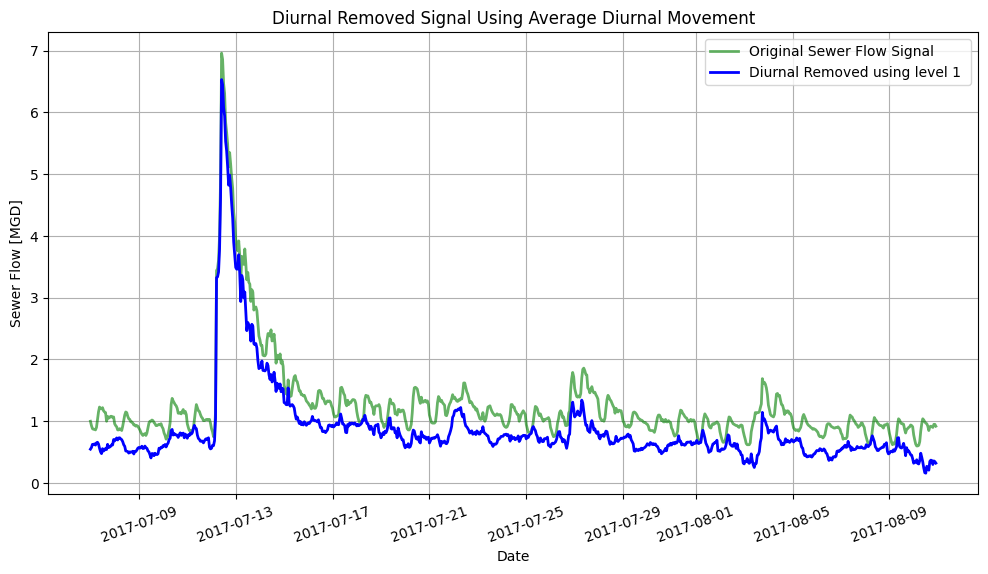

In [108]:
out_df
# slow_df = lyne_hollick_init(MMSD_sewerflow_predicted_precipitation_df, 3, 0.925)
plt.figure(figsize=(12, 6))

col_name = 'MS0311 Flow'
# MMSD_sewerflow_baseflow_df['Date Time'] = pd.to_datetime(MMSD_sewerflow_baseflow_df['Date Time'])
plt.plot(hourly_range, flow_event3_df, linestyle='-', color='g', alpha=0.6, linewidth=2, label="Original Sewer Flow Signal")
plt.plot(hourly_range, flow_event_df, linestyle='-', color='b', alpha=1, linewidth=2, label="Diurnal Removed using level 1 ")
# plt.plot(hourly_range, flow_event2_df, linestyle='-', color='r', alpha=0, linewidth=2.5, label="New: Diurnal Removed using level 2")
# plt.plot(ref_df['Date Time'], ref_df[col_name], linestyle='-', color='g', markersize=6, label="Data Line")
# plt.plot(MMSD_sewerflow_predicted_precipitation_df['Date Time'], MMSD_sewerflow_predicted_precipitation_df[col_name], linestyle='-', color='r', markersize=6, label="Data Line")
# plt.plot(isolated_df['Date Time'], isolated_df[col_name], linestyle='-', color='g', markersize=6, label="Data Line")
# plt.plot(lh_df['Date Time'], lh_df[col_name], linestyle='-', color='r', markersize=6, label="Data Line")
# plt.plot(MMSD_sewerflow_all_df['Date Time'], MMSD_sewerflow_all_df[col_name], linestyle='-', color='b', markersize=6, label="Data Line")

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True)

plt.xlabel("Date")
plt.xticks(rotation=20)
plt.ylabel("Sewer Flow [MGD]")
plt.title("Diurnal Removed Signal Using Average Diurnal Movement")
plt.legend()
plt.show()

In [69]:
flow_data = MMSD_sewerflow_all_df[['Date Time', 'MS0311 Flow']]
flow_data2 = ref_df[['Date Time', 'MS0311 Flow']]
flow_data3 = lh7df[['Date Time', 'MS0311 Flow']]
flow_data4 = isolated_df[['Date Time', 'MS0311 Flow']]
# event = (pd.to_datetime('2015-4-1 0:00'), pd.to_datetime('2015-5-15 23:00'))
hourly_range = pd.date_range(start=event[0], end=event[1] - pd.Timedelta(hours=1), freq='h')
flow_event_df = trim(flow_data, event).iloc[:, 1]
flow_event2_df = trim(flow_data2, event).iloc[:, 1]
flow_event3_df = trim(flow_data3, event).iloc[:, 1]
flow_event4_df = trim(flow_data4, event).iloc[:, 1]


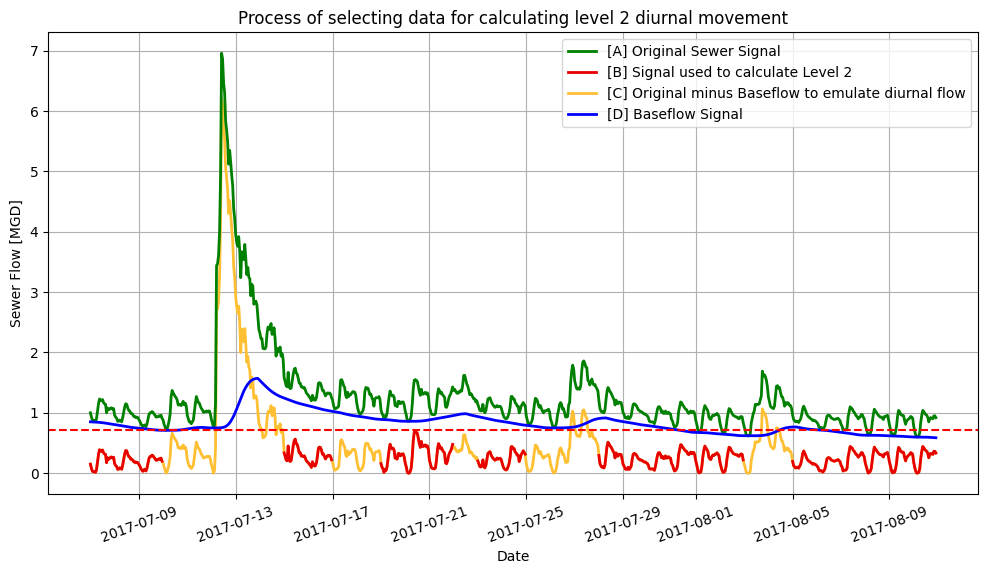

In [98]:
# slow_df = lyne_hollick_init(MMSD_sewerflow_predicted_precipitation_df, 3, 0.925)
plt.figure(figsize=(12, 6))

col_name = 'MS0311 Flow'
# MMSD_sewerflow_baseflow_df['Date Time'] = pd.to_datetime(MMSD_sewerflow_baseflow_df['Date Time'])
l4, = plt.plot(hourly_range, flow_event4_df, linestyle='-', color=(1, 0.75, 0.2), linewidth=2, label="[C] Original minus Baseflow to emulate diurnal flow")

l1, = plt.plot(hourly_range, flow_event_df, linestyle='-', color='g', linewidth=2, label="[A] Original Sewer Signal")
l2, = plt.plot(hourly_range, flow_event3_df, linestyle='-', color='b', linewidth=2, label="[D] Baseflow Signal")
l3, = plt.plot(hourly_range, flow_event2_df, linestyle='-', color=(0.9,0,0), linewidth=2, label="[B] Signal used to calculate Level 2")
# l4, = plt.plot(hourly_range, flow_event4_df, linestyle='-', color='orange', linewidth=2, label="[C] Flow caused by precipitation")
# plt.plot(ref_df['Date Time'], ref_df[col_name], linestyle='-', color='g', markersize=6, label="Data Line")
# plt.plot(MMSD_sewerflow_predicted_precipitation_df['Date Time'], MMSD_sewerflow_predicted_precipitation_df[col_name], linestyle='-', color='r', markersize=6, label="Data Line")
# plt.plot(isolated_df['Date Time'], isolated_df[col_name], linestyle='-', color='g', markersize=6, label="Data Line")
# plt.plot(lh_df['Date Time'], lh_df[col_name], linestyle='-', color='r', markersize=6, label="Data Line")
# plt.plot(MMSD_sewerflow_all_df['Date Time'], MMSD_sewerflow_all_df[col_name], linestyle='-', color='b', markersize=6, label="Data Line")
plt.axhline(y=0.72, color='r', linestyle='--', label='Threshold')
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True)

plt.xlabel("Date")
plt.xticks(rotation=20)
plt.ylabel("Sewer Flow [MGD]")
plt.title("Process of selecting data for calculating level 2 diurnal movement")
plt.legend(handles=[l1, l3, l4, l2])
plt.show()

In [61]:
event = (pd.to_datetime('2017-7-7 0:00'), pd.to_datetime('2017-7-31 23:00'))

MMSD_sewerflow_diurnal_removed_df
lhs = []
for i in range(1,8):
    lh = lyne_hollick_init(MMSD_sewerflow_diurnal_removed_df, i, 0.925)
    lh['Date Time'] = pd.to_datetime(lh['Date Time'])
    
    lh_col = lh[['Date Time', 'MS0311 Flow']]
    lh_event = trim(lh_col, event).iloc[:, 1]
    lhs.append(lh_event)
# lh1 = trim(lyne_hollick_init(MMSD_sewerflow_diurnal_removed_df, 1, 0.925)[['Date Time', 'MS0311 Flow']], event).iloc[:, 1]
# lh2 = trim(lyne_hollick_init(MMSD_sewerflow_diurnal_removed_df, 2, 0.925)[['Date Time', 'MS0311 Flow']], event).iloc[:, 1]
# lh3 = trim(lyne_hollick_init(MMSD_sewerflow_diurnal_removed_df, 3, 0.925)[['Date Time', 'MS0311 Flow']], event).iloc[:, 1]
# lh4 = trim(lyne_hollick_init(MMSD_sewerflow_diurnal_removed_df, 4, 0.925)[['Date Time', 'MS0311 Flow']], event).iloc[:, 1]
# lh5 = trim(lyne_hollick_init(MMSD_sewerflow_diurnal_removed_df, 5, 0.925)[['Date Time', 'MS0311 Flow']], event).iloc[:, 1]
# lh6 = trim(lyne_hollick_init(MMSD_sewerflow_diurnal_removed_df, 6, 0.925)[['Date Time', 'MS0311 Flow']], event).iloc[:, 1]
# lh7 = trim(lyne_hollick_init(MMSD_sewerflow_diurnal_removed_df, 7, 0.925)[['Date Time', 'MS0311 Flow']], event).iloc[:, 1]


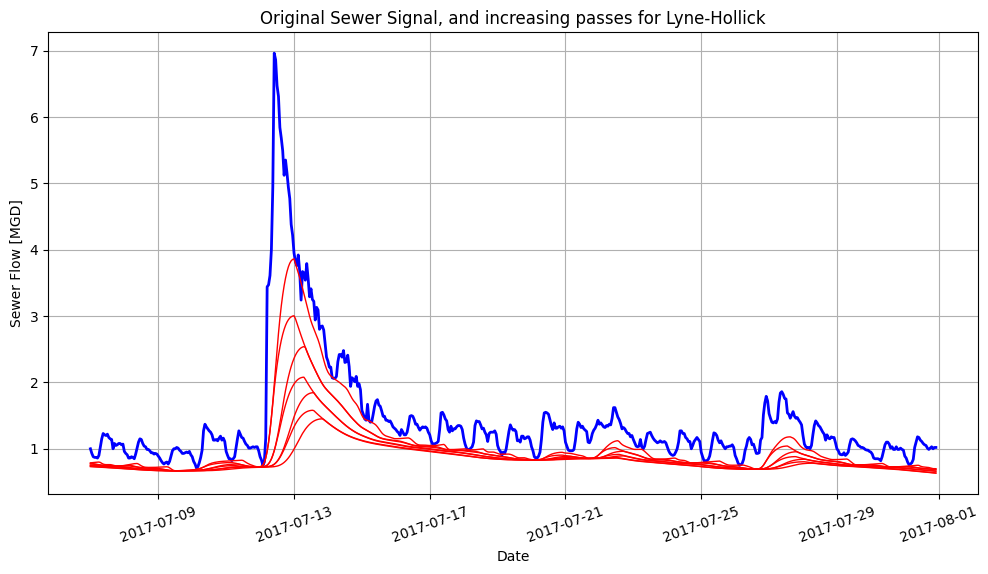

In [49]:
# slow_df = lyne_hollick_init(MMSD_sewerflow_predicted_precipitation_df, 3, 0.925)
plt.figure(figsize=(12, 6))

col_name = 'MS0311 Flow'
# MMSD_sewerflow_baseflow_df['Date Time'] = pd.to_datetime(MMSD_sewerflow_baseflow_df['Date Time'])
plt.plot(hourly_range, flow_event_df, linestyle='-', color='b', linewidth=2, label="Data Line")

for lh in lhs:
    
    plt.plot(hourly_range, lh, linestyle='-', color='r', linewidth=1, label="Data Line")
# plt.plot(hourly_range, flow_event2_df, linestyle='-', color='r', linewidth=6, label="Data Line")
# plt.plot(hourly_range, flow_event3_df, linestyle='-', color='g', linewidth=6, label="Data Line")
# plt.plot(ref_df['Date Time'], ref_df[col_name], linestyle='-', color='g', markersize=6, label="Data Line")
# plt.plot(MMSD_sewerflow_predicted_precipitation_df['Date Time'], MMSD_sewerflow_predicted_precipitation_df[col_name], linestyle='-', color='r', markersize=6, label="Data Line")
# plt.plot(isolated_df['Date Time'], isolated_df[col_name], linestyle='-', color='g', markersize=6, label="Data Line")
# plt.plot(lh_df['Date Time'], lh_df[col_name], linestyle='-', color='r', markersize=6, label="Data Line")
# plt.plot(MMSD_sewerflow_all_df['Date Time'], MMSD_sewerflow_all_df[col_name], linestyle='-', color='b', markersize=6, label="Data Line")

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True)

plt.xlabel("Date")
plt.xticks(rotation=20)
plt.ylabel("Sewer Flow [MGD]")
plt.title("Original Sewer Signal, and increasing passes for Lyne-Hollick")
plt.show()